# ФКН ВШЭ: Промышленная разработка
## Практическое задание 10. Анализ логов
## Общая информация
Дата лекции: 29.11.2021

Срок сдачи: до 13.12.2021

## Критерии оценивания:
Есть ссылка на книжку на github: +20

В книжке все сделано аккуратно, оформлено и прокомментировано: +10

Описана процедура измерения, произведено снятие данных с сенсора:  +10

Данные проанализированы и сделан вывод: +20

Выдвинуты гипотезы о наличии неустранимых погрешностей в процессе сбора и анализа данных. Предложены способы устранения влияния таких погрешностей на вывод: +20

Построена физическая модель: +20

## Команда: Study Buddy

Состав команды: Корытник Анна, Крапивина Мария, Шепелин Дмитрий, Шакиров Айвар, Семён Степанов, Хайбулин Даниэль

## Задача 

Прочитать данные с видеофайла, организовать пайплайн определения шума и подсчета пульса по чистым данным

In [1]:
# Импортируем библиотеки
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
# Считываем видеоданные
vid = imageio.get_reader('IMG_2338.mov')
movie = np.array([im for im in vid.iter_data()], dtype=np.uint8)

The frame size for reading (1080, 1920) is different from the source frame size (1920, 1080).


In [3]:
# Проверим получившийся массив
np.info(movie)

class:  ndarray
shape:  (1834, 1920, 1080, 3)
strides:  (6220800, 3240, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x2e7c46ae040
byteorder:  little
byteswap:  False
type: uint8


In [4]:
# Для каждого изображения найдем медиану цвета для дальнейшей визуализации
color_array = np.empty([movie.shape[0], 3])
for i in range(movie.shape[0]):
    color_array[i] = np.array([np.median(movie[i,:,:,0]),np.median(movie[i,:,:,1]),np.median(movie[i,:,:,2])])

In [5]:
colors.rgb_to_hsv((0.1, 0.1, 0.2))

array([0.66666667, 0.5       , 0.2       ])

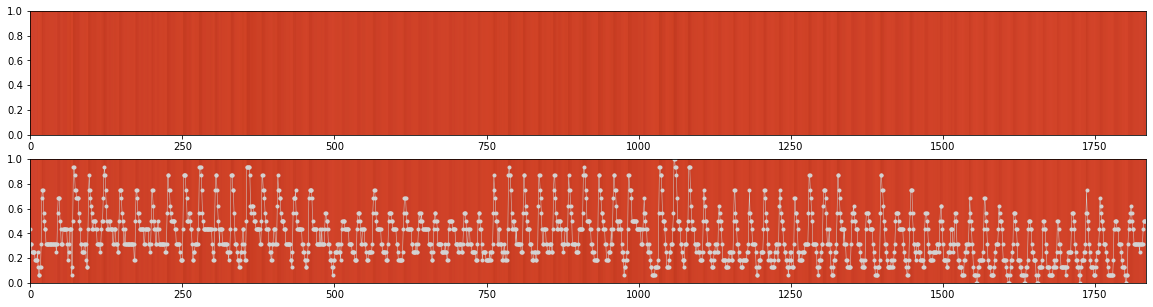

In [6]:
# Визуализируем график медианного цвета в виде шкалы
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,5));
barlists = []
barlists.append(axes[0].bar(range(movie.shape[0]), 1))
barlists.append(axes[1].bar(range(movie.shape[0]), 1))
for i in range(movie.shape[0]):
    color = colors.to_rgb(color_array[i]/255)
    for j in [0, 1]:
        barlists[j][i].set_color(color)

# Псотавим предел для аккуратности
for j in [0, 1]:
    axes[j].set_ylim([0, 1])
    axes[j].set_xlim([0, movie.shape[0]])

# Найдем насыщенность по модели цвета hsv для каждой медианы цвета
h_array = np.empty([movie.shape[0], 1])
for i in range(movie.shape[0]):
    h_array[i] = 1 - colors.rgb_to_hsv(colors.to_rgb(color_array[i]/255))[2]

# Насыщенность можно привести к данных у течении пульса, если нормализовать (это и для визуализации полезно)
pulse_data = ((h_array - np.min(h_array)) / (np.max(h_array) - np.min(h_array))).flatten()

axes[1].plot(range(movie.shape[0]), pulse_data, color='lightgray',linestyle='-',linewidth=0.5,marker='.')

plt.show()

## Решение 1
Для поиска пиков в темпе пульса подберем нужный параметр distance в find_peaks

In [7]:
# Зафиксируем информацию о длительности видео
fps = 30
video_time = (movie.shape[0] / fps) / 60

In [8]:
from scipy.signal import find_peaks

def draw_picks(pulse_data, distance, title=""):
    peaks_ind = find_peaks(pulse_data, distance=distance)[0]

    # Нарисуем график пиков
    ax, fig = plt.subplots(figsize=(20, 4))
    plt.scatter(peaks_ind, pulse_data[peaks_ind], color='red')
    plt.plot(range(pulse_data.shape[0]), pulse_data, color='gray')
    plt.title(title)
    plt.show()
    
    return peaks_ind

def print_pulse(peaks_ind):
    print("Найденный пульс", len(peaks_ind) / video_time)

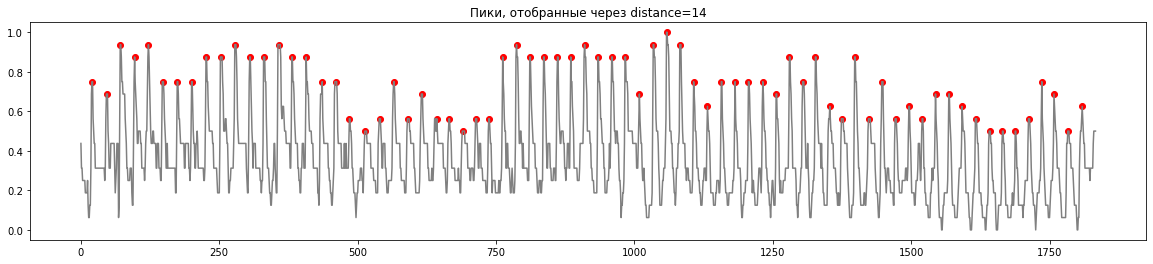

Найденный пульс 71.64667393675026


In [9]:
print_pulse(draw_picks(pulse_data, 14, "Пики, отобранные через distance=14"))

## Решение 2
Уберем шум, используя [FFT](https://scipy-lectures.org/intro/scipy/auto_examples/solutions/plot_fft_image_denoise.html)

In [10]:
def denoise_vector(vector, keep_fraction = 0.1):
    assert 0 < keep_fraction < 0.5
    
    fft_data = np.fft.fft(vector)
    fft_data[int(vector.shape[0] * keep_fraction) : int(vector.shape[0] * (1 - keep_fraction))] = 0
    return np.real(np.fft.ifft(fft_data))

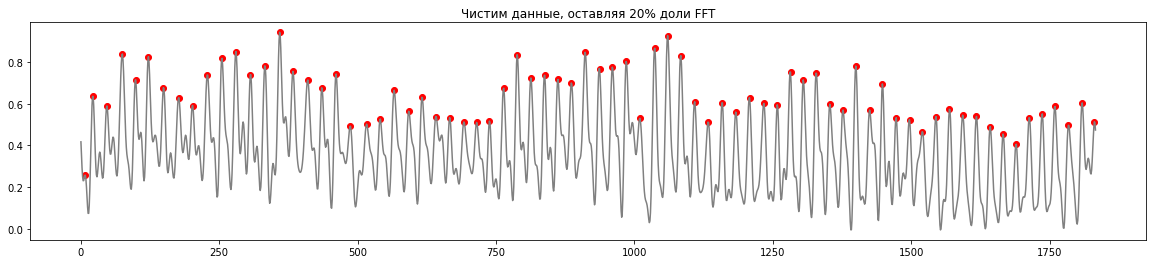

Найденный пульс 73.60959651035986


In [11]:
new_pulse = denoise_vector(pulse_data, 0.1)
print_pulse(draw_picks(new_pulse, 14, "Чистим данные, оставляя 20% доли FFT"))

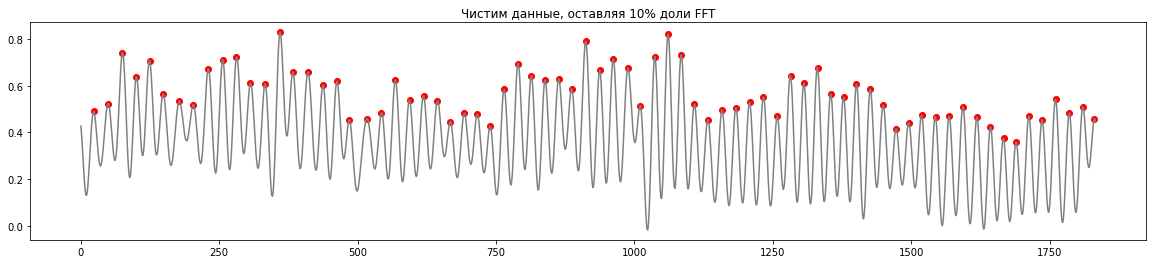

Найденный пульс 72.62813522355506


In [12]:
new_pulse = denoise_vector(pulse_data, 0.05)
print_pulse(draw_picks(new_pulse, 14, "Чистим данные, оставляя 10% доли FFT"))

## Решение 3
Будем использовать [сглаживание](https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way), чтобы избавиться от шума и найти настоящие спуски/падения

In [13]:
def smooth(vector, length):
    box = np.ones(length) / length
    return np.convolve(vector, box, mode='same')

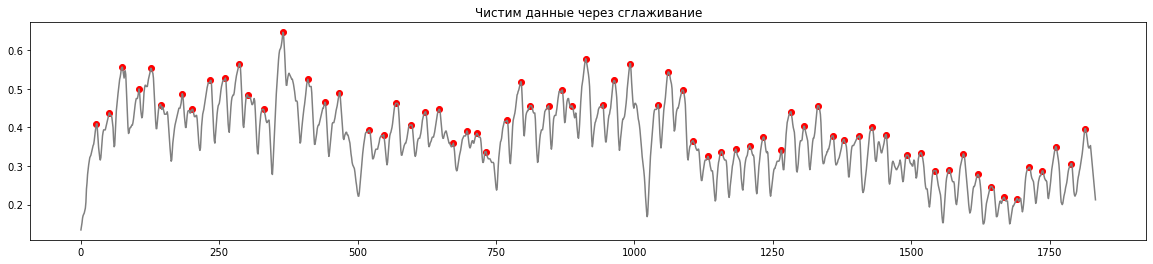

Найденный пульс 67.72082878953107


In [14]:
print_pulse(draw_picks(smooth(pulse_data, 20), 14, "Чистим данные через сглаживание"))

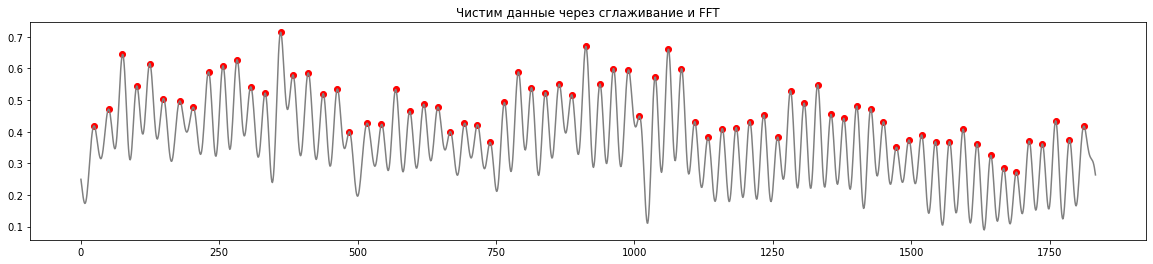

Найденный пульс 71.64667393675026


In [15]:
smoothed = smooth(pulse_data, 14)
new_pulse = denoise_vector(smoothed, 0.05)
print_pulse(draw_picks(new_pulse, 14, "Чистим данные через сглаживание и FFT"))

## Решение 4
Мы получили три параметра, по которым можно построить сетку и найти среднее значение пульса

In [16]:
pulses = []
for smooth_param in [1, 5, 10, 15, 20]:
    for denoise in [0.04, 0.06, 0.08, 0.1, 0.12]:
        for peaks_param in [5, 10, 15, 20, 25]:
            smoothed = smooth(pulse_data, smooth_param)
            new_pulse = denoise_vector(smoothed, denoise)
            peaks_ind = find_peaks(new_pulse, distance=peaks_param)[0]
            pulses.append(len(peaks_ind))

mean_peaks = np.array(pulses).mean()
print("Конечное значение пульса", mean_peaks / video_time)

Конечное значение пульса 69.4874591057797


## Выводы

Несмотря на различные методы, которые мы использовали, стоит задаться вопросом о неустранимости некоторых погрешностей. Проблема таких неустранимостей в том, что при попытке получить "чистый сигнал" мы теряем данные. Мы можем предложить использовать более точные преборы, но всегда будут физические колебания, которые не позволят считывать прямые данные. То есть нет какого-то достаточного предела приборов-рецепторов: получая большую точность, мы получаем больше чистых данных, а на основе них можем найти пользу такой точности. Но это все гипотезы, и практическая задача может иметь некоторый достаточный уровень точности показателей. 

Анализ датчиков (в частности видеоряда) может дать интересные результаты. Это открывает ряд дискуссий от возможностей денойзинга, до того, насколько много информации можно узнать из собранных через IOT данных. В данном случае мы применили ряд методик, чтобы получить пульс, однако эту тему можно развить и дальше, фиксируя больше данных и используя больше инструментов.